In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from scipy.optimize import bisect, brentq, newton
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, TheilSenRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

1. Исходные данные

In [2]:
# Фиксация генератора случайных чисел
random_seed = 1937
np.random.seed(random_seed)

# Значения предикторов для прогноза целевой переменной
A_max = (1800, 1500, 1800, 2000, 1500)

# Отн. погрешности измерений значений элементов матрицы A_h и вектора b_d
k_A = 0.01
k_b = 0.05

# Отн. размер тестовой выборки
test_size = 0.3

2. Загрузка датасетов

In [3]:
# Загрузка точных коэффициентов регрессии (для контроля обучения моделей)
z_acc = pd.read_excel('C:\Datasets/dataset_z_acc.xlsx')

In [4]:
df = pd.read_excel('C:\Datasets/dataset_1.xlsx')
df.round(2)

,A_h_1,A_h_2,A_h_3,A_h_4,A_h_5,b_d
0,400.55,198.31,450.98,604.77,200.18,49.74
1,401.92,199.81,451.80,603.09,201.09,49.71
2,402.32,201.75,449.05,604.77,199.56,54.21
3,400.59,200.83,450.81,603.49,201.93,51.76
4,399.40,200.61,454.86,600.54,200.22,53.06
...,...,...,...,...,...,...
995,834.91,419.82,954.10,1257.51,424.43,110.52
996,843.21,415.82,964.41,1259.49,427.98,114.27
997,841.24,419.41,968.42,1268.53,429.17,109.03
998,842.05,416.33,962.46,1247.15,428.48,105.98


3. Попарные графики рассеяния

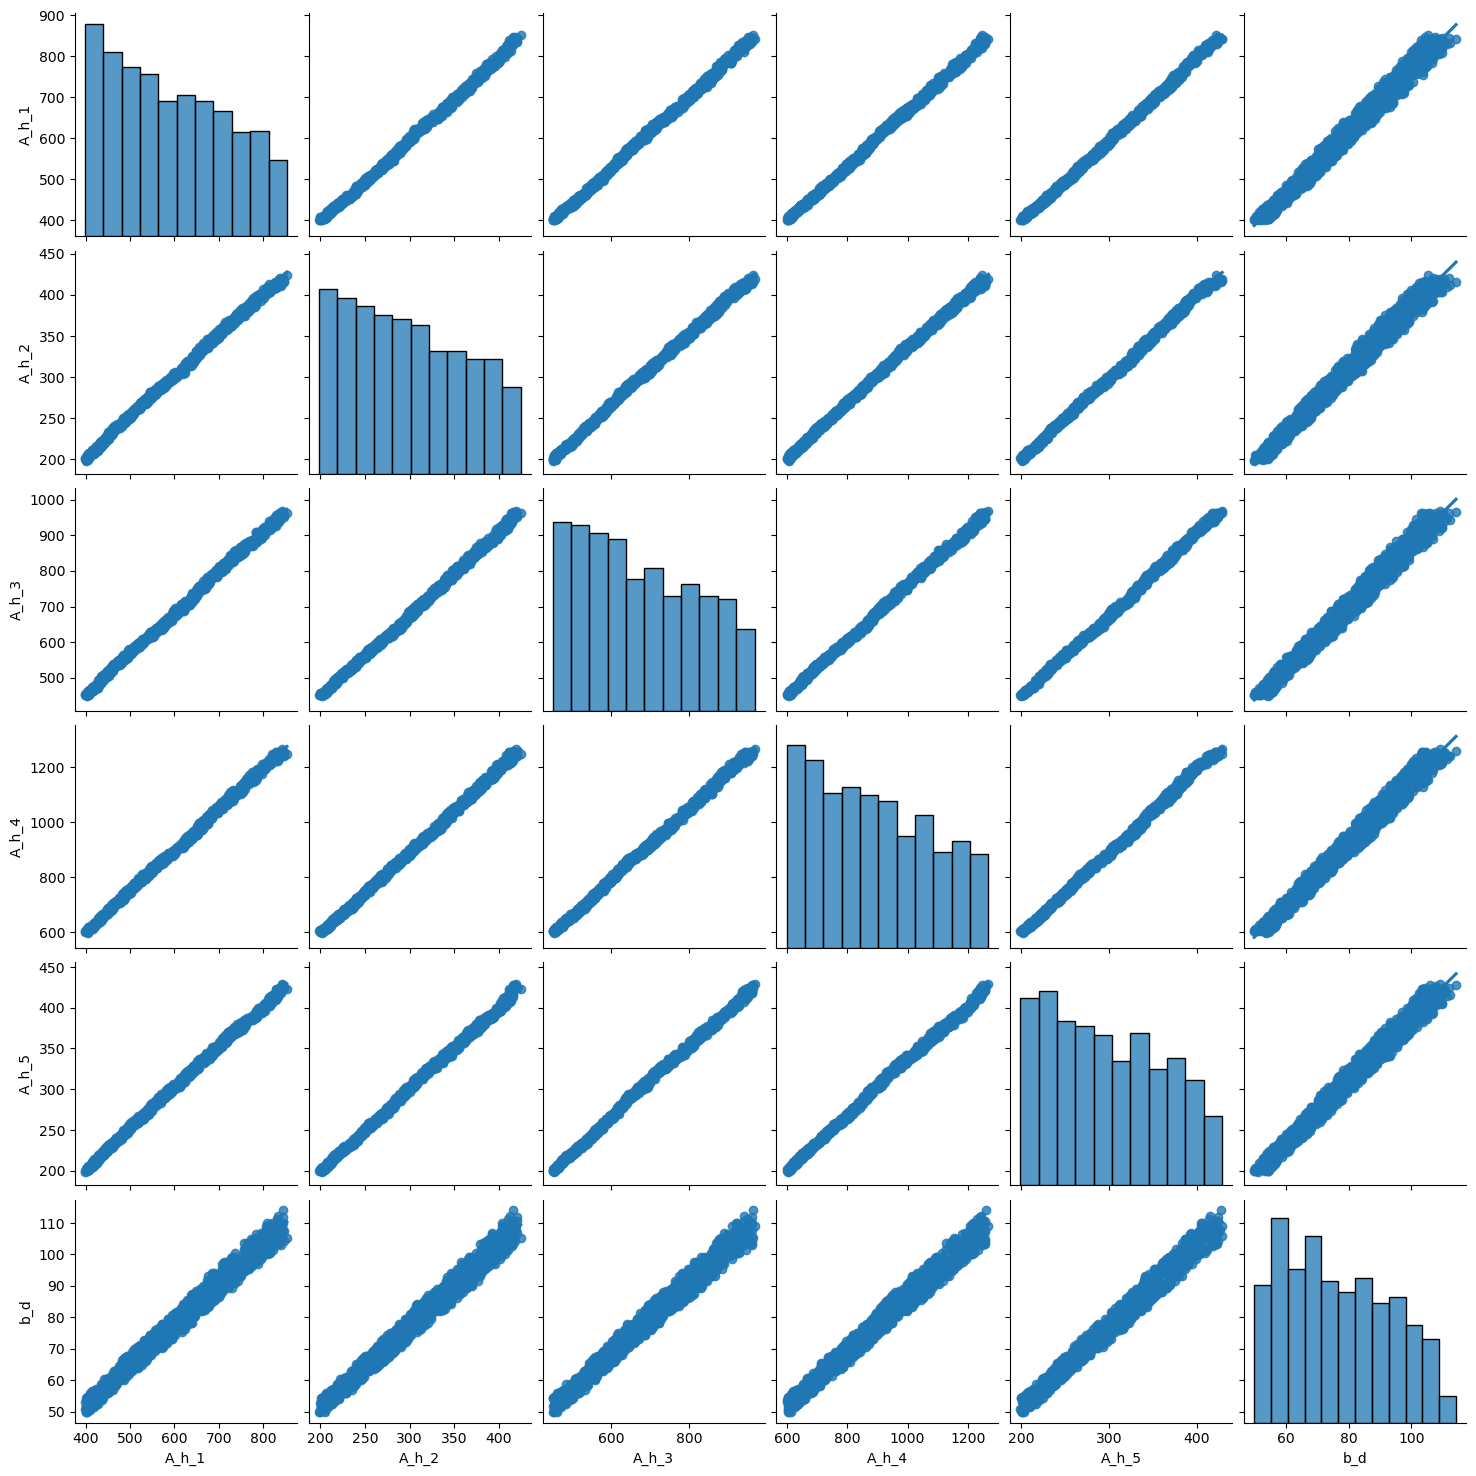

In [5]:
sns.pairplot(df, kind="reg")
plt.show()

4. Выделение матрицы A и вектора b из df

In [6]:
A = df.iloc[:, :-1].values
b = df.iloc[:, -1].values
cond_A = np.linalg.cond(A.T @ A)
det_A = np.linalg.det(A.T @ A)

print(f'Число обусловленности матрицы А: cond(A_h) = {cond_A.round(1)}')
print("Определитель матрицы A:", det_A.round(1))

Число обусловленности матрицы А: cond(A_h) = 442685.4
Определитель матрицы A: 2.931932940022398e+25


5. Разбиение на обучающую и тестовые выборки

In [7]:
X_train, X_test, y_train, y_test = train_test_split(A, 
                                                    b,
                                                    test_size=test_size,
                                                    random_state=random_seed)                                                 

6. Масштабирование признаков и вектора A_max

In [8]:
sc = MaxAbsScaler()
X_train_std = sc.fit_transform(X_train) 
X_test_std = sc.transform(X_test)

In [9]:
A_max_std = sc.transform([A_max])
A_max_std.round(3)

array([[2.125, 3.567, 1.859, 1.577, 3.495]])

7. Обучение моделей регрессоров на train-данных

In [10]:
metrics = {}

In [11]:
lr = LinearRegression()
model_lr = lr.fit(X_train_std, y_train)

y_lr_pred = model_lr.predict(X_test_std)
y_lr_pred_train = model_lr.predict(X_train_std)

rmse_lr_train = np.sqrt(mean_squared_error(y_train, y_lr_pred_train)).round(3)
rmse_lr_test = np.sqrt(mean_squared_error(y_test, y_lr_pred)).round(3)
mae_lr_train = mean_absolute_error(y_train, y_lr_pred_train).round(3)
mae_lr_test = mean_absolute_error(y_test, y_lr_pred).round(3)
r2_lr_train = r2_score(y_train, y_lr_pred_train).round(3)
r2_lr_test = r2_score(y_test, y_lr_pred).round(3)
b_max_lr = model_lr.predict(A_max_std)[0].round(3)
metrics['LinRegr'] = (r2_lr_train, r2_lr_test, b_max_lr)

print(f'RMSE train: {rmse_lr_train}')
print(f'RMSE test:  {rmse_lr_test}')
print()
print(f'MAE train:  {mae_lr_train}')
print(f'MAE test:   {mae_lr_test}')
print()
print(f'R2 train:   {r2_lr_train}')
print(f'R2 test:    {r2_lr_test}')
print()
print(f'b max: {b_max_lr}')
print()
print('Коэффициенты регрессии:')
print(pd.DataFrame(model_lr.coef_[:], columns=['k']).round(3))
print(f'Свободный член регрессии  a0 =  {model_lr.intercept_.round(3)}')

RMSE train: 2.317
RMSE test:  2.318

MAE train:  1.966
MAE test:   1.913

R2 train:   0.981
R2 test:    0.979

b max: 373.321

Коэффициенты регрессии:
        k
0  49.003
1  64.257
2  11.325
3 -38.252
4  22.650
Свободный член регрессии  a0 =  0.069


In [12]:
rid = Ridge()
rid_parameters = {'alpha': np.logspace(-5, 5, num=51), 
                  'random_state':[1, 7, 42, 100]
}
model_rid = GridSearchCV(estimator=rid,
                   param_grid=rid_parameters,
                   scoring='r2', # 'neg_mean_absolute_error'
                   n_jobs=-1,
                   cv=5)
model_rid.fit(X_train_std, y_train)

y_rid_pred = model_rid.predict(X_test_std)
y_rid_pred_train = model_rid.predict(X_train_std)

rmse_rid_train = np.sqrt(mean_squared_error(y_train, y_rid_pred_train)).round(3)
rmse_rid_test = np.sqrt(mean_squared_error(y_test, y_rid_pred)).round(3)
mae_rid_train = mean_absolute_error(y_train, y_rid_pred_train).round(3)
mae_rid_test = mean_absolute_error(y_test, y_rid_pred).round(3)
r2_rid_train = r2_score(y_train, y_rid_pred_train).round(3)
r2_rid_test = r2_score(y_test, y_rid_pred).round(3)
b_max_rid = model_rid.predict(A_max_std)[0].round(3)
metrics['Ridge'] = (r2_rid_train, r2_rid_test, b_max_rid)

print(f'RMSE train: {rmse_rid_train}')
print(f'RMSE test:  {rmse_rid_test}')
print()
print(f'MAE train:  {mae_rid_train}')
print(f'MAE test:   {mae_rid_test}')
print()
print(f'R2 train:   {r2_rid_train}')
print(f'R2 test:    {r2_rid_test}')
print()
print(f'b max: {b_max_rid}')
model_rid.best_params_

RMSE train: 2.318
RMSE test:  2.311

MAE train:  1.969
MAE test:   1.908

R2 train:   0.981
R2 test:    0.979

b max: 353.358


{'alpha': 0.003981071705534973, 'random_state': 1}

In [13]:
las = Lasso()
las_parameters = {'alpha': np.logspace(-5, 5, num=51), 
                  'random_state':[1, 7, 42, 100]
}
model_las = GridSearchCV(estimator=las,
                   param_grid=las_parameters,
                   scoring='r2', # 'neg_mean_absolute_error'
                   n_jobs=-1,
                   cv=5)
model_las.fit(X_train_std, y_train)

y_las_pred = model_las.predict(X_test_std)
y_las_pred_train = model_las.predict(X_train_std)

rmse_las_train = np.sqrt(mean_squared_error(y_train, y_las_pred_train)).round(3)
rmse_las_test = np.sqrt(mean_squared_error(y_test, y_las_pred)).round(3)
mae_las_train = mean_absolute_error(y_train, y_las_pred_train).round(3)
mae_las_test = mean_absolute_error(y_test, y_las_pred).round(3)
r2_las_train = r2_score(y_train, y_las_pred_train).round(3)
r2_las_test = r2_score(y_test, y_las_pred).round(3)
b_max_las = model_las.predict(A_max_std)[0].round(3)
metrics['Lasso'] = (r2_las_train, r2_las_test, b_max_las)

print(f'RMSE train: {rmse_las_train}')
print(f'RMSE test:  {rmse_las_test}')
print()
print(f'MAE train:  {mae_las_train}')
print(f'MAE test:   {mae_las_test}')
print()
print(f'R2 train:   {r2_las_train}')
print(f'R2 test:    {r2_las_test}')
print()
print(f'b max: {b_max_las}')
model_las.best_params_

RMSE train: 2.32
RMSE test:  2.305

MAE train:  1.968
MAE test:   1.91

R2 train:   0.981
R2 test:    0.979

b max: 340.636


{'alpha': 0.0002511886431509582, 'random_state': 1}

In [14]:
en = ElasticNet()
en_parameters = {'alpha': np.logspace(-5, 5, num=51),
                 'l1_ratio': (0.05, 0.1, 0.3, 0.5, 0.7, 0.9),
                 'random_state':[1, 7, 42, 100]
}
model_en = GridSearchCV(estimator=en,
                   param_grid=en_parameters,
                   scoring='r2', # 'neg_mean_absolute_error'
                   n_jobs=-1,
                   cv=5)
model_en.fit(X_train_std, y_train)

y_en_pred = model_en.predict(X_test_std)
y_en_pred_train = model_en.predict(X_train_std)

rmse_en_train = np.sqrt(mean_squared_error(y_train, y_en_pred_train)).round(3)
rmse_en_test = np.sqrt(mean_squared_error(y_test, y_en_pred)).round(3)
mae_en_train = mean_absolute_error(y_train, y_en_pred_train).round(3)
mae_en_test = mean_absolute_error(y_test, y_en_pred).round(3)
r2_en_train = r2_score(y_train, y_en_pred_train).round(3)
r2_en_test = r2_score(y_test, y_en_pred).round(3)
b_max_en = model_en.predict(A_max_std)[0].round(3)
metrics['ElastNet'] = (r2_en_train, r2_en_test, b_max_en)

print(f'RMSE train: {rmse_en_train}')
print(f'RMSE test:  {rmse_en_test}')
print()
print(f'MAE train:  {mae_en_train}')
print(f'MAE test:   {mae_en_test}')
print()
print(f'R2 train:   {r2_en_train}')
print(f'R2 test:    {r2_en_test}')
print()
print(f'b max: {b_max_en}')
model_en.best_params_

RMSE train: 2.318
RMSE test:  2.308

MAE train:  1.967
MAE test:   1.909

R2 train:   0.981
R2 test:    0.979

b max: 348.531


{'alpha': 1e-05, 'l1_ratio': 0.05, 'random_state': 1}

In [15]:
tsr = TheilSenRegressor()
tsr_parameters = {'random_state':[1, 7, 42, 100]
}
model_tsr = GridSearchCV(estimator=tsr,
                   param_grid=tsr_parameters,
                   scoring='r2', # 'neg_mean_absolute_error'
                   n_jobs=-1,
                   cv=5)
model_tsr.fit(X_train_std, y_train)

y_tsr_pred = model_tsr.predict(X_test_std)
y_tsr_pred_train = model_tsr.predict(X_train_std)

rmse_tsr_train = np.sqrt(mean_squared_error(y_train, y_tsr_pred_train)).round(3)
rmse_tsr_test = np.sqrt(mean_squared_error(y_test, y_tsr_pred)).round(3)
mae_tsr_train = mean_absolute_error(y_train, y_tsr_pred_train).round(3)
mae_tsr_test = mean_absolute_error(y_test, y_tsr_pred).round(3)
r2_tsr_train = r2_score(y_train, y_tsr_pred_train).round(3)
r2_tsr_test = r2_score(y_test, y_tsr_pred).round(3)
b_max_tsr = model_tsr.predict(A_max_std)[0].round(3)
metrics['TheilSen'] = (r2_tsr_train, r2_tsr_test, b_max_tsr)

print(f'RMSE train: {rmse_tsr_train}')
print(f'RMSE test:  {rmse_tsr_test}')
print()
print(f'MAE train:  {mae_tsr_train}')
print(f'MAE test:   {mae_tsr_test}')
print()
print(f'R2 train:   {r2_tsr_train}')
print(f'R2 test:    {r2_tsr_test}')
print()
print(f'b max: {b_max_tsr}')
model_tsr.best_params_

RMSE train: 2.321
RMSE test:  2.325

MAE train:  1.965
MAE test:   1.915

R2 train:   0.981
R2 test:    0.979

b max: 377.779


{'random_state': 1}

8. Средние значения метрик регрессоров и целевой переменной b

In [16]:
r2_train_values = [metrics[key][-3] for key in metrics]
r2_train_mean = sum(r2_train_values) / len(r2_train_values)
r2_test_values = [metrics[key][-2] for key in metrics]
r2_test_mean = sum(r2_test_values) / len(r2_test_values)
b_max_values = [metrics[key][-1] for key in metrics]
b_max_mean = sum(b_max_values) / len(b_max_values)
metrics['Mean'] = (r2_train_mean.round(3), r2_test_mean.round(3), b_max_mean.round(3))

print(f'b_mean: {b_max_mean.round(3)}')

b_mean: 358.725


9. Определение коэффициента регуляризации alpha

In [17]:
# Функция вычисления обобщенной невязки delta_residual
def calculate_delta_residual(alpha, X, y, h, d):
    z = np.linalg.inv(X.T @ X + alpha * np.eye(X.shape[1])) @ X.T @ y
    residual = np.linalg.norm(X @ z - y)
    norm = np.linalg.norm(z)
    delta_residual = residual**2 - (h * norm + d)**2

    return delta_residual

X_h = X_train_std
y_d = y_train
# Вычисление точности задания матрицы A: h = ||A - A_h|| и вектора b: d = ||b - b_d||
h = k_A * np.linalg.norm(X_h)
d = k_b * np.linalg.norm(y_d)

# Поиск коэффициента регуляризации alpha
alpha = newton(calculate_delta_residual, x0=1e-7, args=(X_h, y_d, h, d), tol=1e-7)
# alpha = bisect(calculate_delta_residual, 1e-7, 1e5)
# alpha = brentq(calculate_delta_residual, a=1e-7, b=1e5, xtol=1e-5)

print(f"Коэффициент регуляризации alpha = {alpha:.{2}e}")

Коэффициент регуляризации alpha = 9.74e+01


10. Регуляризированное решение системы уравнений

In [18]:
# Регуляризованное решение
z_hd = np.linalg.inv(X_h.T @ X_h + alpha * np.eye(X_h.shape[1])) @ X_h.T @ y_d

y_reg_hd_pred = X_test_std @ z_hd
y_reg_hd_pred_train = X_train_std @ z_hd

rmse_reg_hd_train = np.sqrt(mean_squared_error(y_train, y_reg_hd_pred_train)).round(3)
rmse_reg_hd_test = np.sqrt(mean_squared_error(y_test, y_reg_hd_pred)).round(3)
mae_reg_hd_train = mean_absolute_error(y_train, y_reg_hd_pred_train).round(3)
mae_reg_hd_test = mean_absolute_error(y_test, y_reg_hd_pred).round(3)
r2_reg_hd_train = r2_score(y_train, y_reg_hd_pred_train).round(3)
r2_reg_hd_test = r2_score(y_test, y_reg_hd_pred).round(3)
b_max_reg_hd = np.sum(A_max_std * z_hd).round(3)
metrics['Regularized'] = (r2_reg_hd_train, r2_reg_hd_test, b_max_reg_hd)

print(f'RMSE train: {rmse_reg_hd_train}')
print(f'RMSE test:  {rmse_reg_hd_test}')
print()
print(f'MAE train:  {mae_reg_hd_train}')
print(f'MAE test:   {mae_reg_hd_test}')
print()
print(f'R2 train:   {r2_reg_hd_train}')
print(f'R2 test:    {r2_reg_hd_test}')
print()
print(f'b_max_reg_hd: {b_max_reg_hd}')

RMSE train: 4.673
RMSE test:  4.653

MAE train:  3.963
MAE test:   3.951

R2 train:   0.923
R2 test:    0.916

b_max_reg_hd: 262.794


In [19]:
N_feat = X_h.shape[1]

print("Точные масштабированные коэффициенты регрессии:")
for i in range(0, N_feat): 
    print((np.array(z_acc)[i] * np.amax(A[:, i])).round(2))
print()
print(f"Коэффициент регуляризации alpha = {alpha:.{3}e}")
print("Регуляризованные масштабированные коэффициенты регрессии:")
for i in range(0, N_feat): 
    print(z_hd[i].round(2))

Точные масштабированные коэффициенты регрессии:
[34.11]
[14.85]
[29.05]
[25.37]
[6.87]

Коэффициент регуляризации alpha = 9.740e+01
Регуляризованные масштабированные коэффициенты регрессии:
20.79
21.07
20.69
20.79
20.67


11. Точный прогноз целевой переменной b

In [20]:
b_max_acc = np.sum(A_max * np.array(z_acc).reshape(-1))
metrics['Accurate'] = ('', '', b_max_acc)

print(f'Accurate b_max: {b_max_acc}')

Accurate b_max: 242.5


12. Сводная таблица метрик и прогнозов моделей

In [21]:
df_metrics = pd.DataFrame(metrics)
df_metrics.index = ['R2 train', 'R2 test', 'b_max']

print(f"Коэффициент регуляризации alpha = {alpha:.{3}e}")
df_metrics

Коэффициент регуляризации alpha = 9.740e+01


,LinRegr,Ridge,Lasso,ElastNet,TheilSen,Mean,Regularized,Accurate
R2 train,0.981,0.981,0.981,0.981,0.981,0.981,0.923,
R2 test,0.979,0.979,0.979,0.979,0.979,0.979,0.916,
b_max,373.321,353.358,340.636,348.531,377.779,358.725,262.794,242.5


Приложение. Графики зависимостей обобщенной невязки и корней уравнения от коэффициента регуляризации

In [22]:
# Параметры регуляризации
alpha_values = np.logspace(5, -5, num=10000)

# Переменные для хранения оптимальных значений
app_alpha = None
app_z = None
min_delta_residual = np.inf

# Цикл для перебора параметра регуляризации
delta_residuals = []
residuals = []
norms = []
zs = []

i = 0
for alpha in alpha_values:
    i += 1
    # Регуляризованное решение
    z_0 = np.linalg.inv(X_h.T @ X_h + alpha * np.eye(X_h.shape[1])) @ X_h.T @ y_d
   
    # Вычисление невязки и нормы
    residual = np.linalg.norm(X_h @ z_0 - y_d)
    norm = np.linalg.norm(z_0)
    delta_residual = residual - h * norm - d
        
    if np.abs(delta_residual) < min_delta_residual:
        min_delta_residual = delta_residual
        app_alpha = alpha
        app_z = z_0
    
    delta_residuals.append(delta_residual)
    residuals.append(residual)
    norms.append(norm)
    zs.append(z_0)

print(f"Appr. alpha = {app_alpha:.{4}e}")
print(f"Appr. z = {app_z}")

Appr. alpha = 9.7431e+01
Appr. z = [20.78507032 21.06482102 20.68703231 20.78554058 20.67368534]


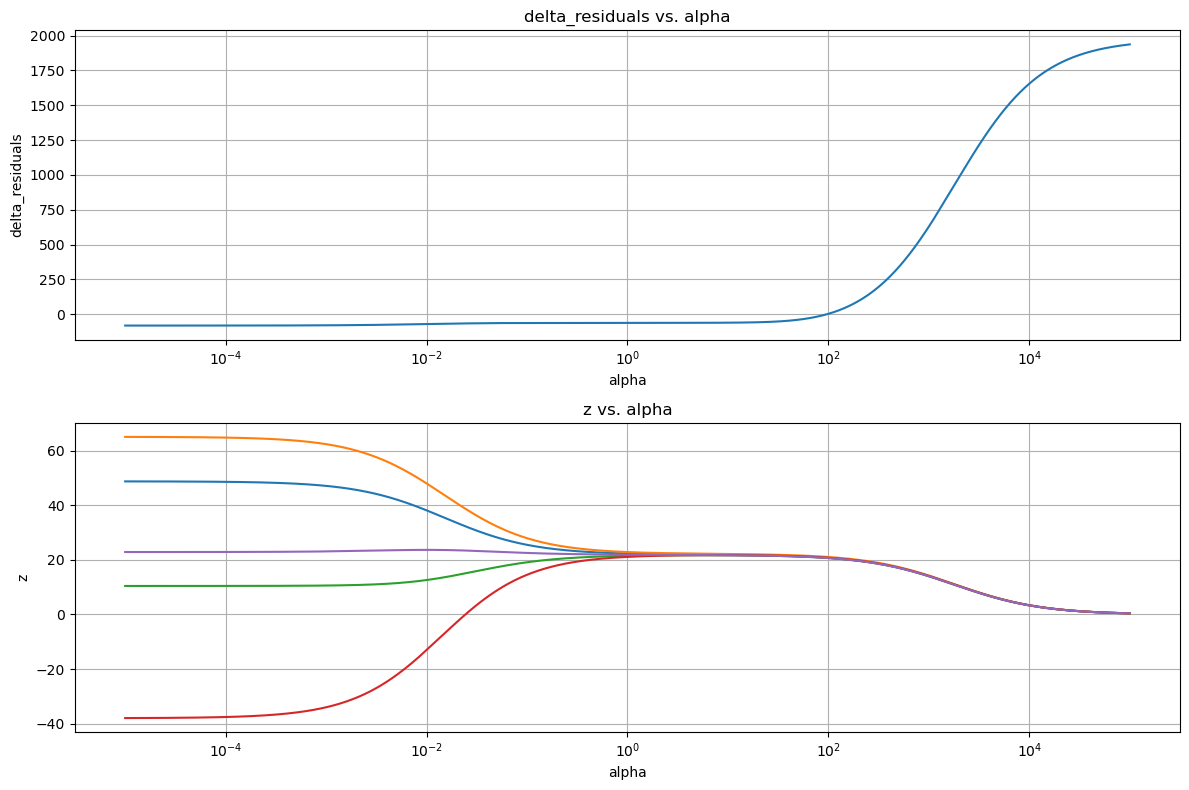

In [23]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(alpha_values, delta_residuals)
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('delta_residuals')
plt.title('delta_residuals vs. alpha')
plt.grid(True)
print()

plt.subplot(2, 1, 2)
plt.plot(alpha_values, zs)
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('z')
plt.title('z vs. alpha')
plt.grid(True)

plt.tight_layout()
plt.show()